# Mohid Munir  21i-1719

# Question#1

#Installing libs  and check versions

In [ ]:
# If you're on Colab, most of these exist already. This is safe to run.
!pip -q install kagglehub scikit-image opencv-python umap-learn --upgrade

import sys, torch, torchvision, sklearn, cv2, PIL, numpy as np, pandas as pd
print("Python:", sys.version.split()[0])
print("PyTorch:", torch.__version__)
print("TorchVision:", torchvision.__version__)
print("OpenCV:", cv2.__version__)
print("Pandas:", pd.__version__)


Python: 3.12.11
PyTorch: 2.8.0+cu126
TorchVision: 0.23.0+cu126
OpenCV: 4.12.0
Pandas: 2.2.2


#Downloading the Kaggle dataset via kagglehub

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("robinreni/signature-verification-dataset")

print("Path to dataset files:", path)


100%|██████████| 601M/601M [00:28<00:00, 22.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/robinreni/signature-verification-dataset/versions/2


In [ ]:
from pathlib import Path

DATA_DIR = Path(path) / "sign_data"  # new correct subfolder

print("DATA_DIR =", DATA_DIR.resolve())

# Now CSVs live directly under sign_data/
csv_train = DATA_DIR / "train_data.csv"
csv_test  = DATA_DIR / "test_data.csv"

assert csv_train.exists() and csv_test.exists(), "train/test CSV files not found."

print("\nCSV files:")
print("train_data.csv:", csv_train)
print("test_data.csv :", csv_test)

# Show the main subfolders so we’re sure
for sub in ["train", "test"]:
    d = DATA_DIR / sub
    print(f"\n{sub.upper()} folders:", [x.name for x in sorted(d.iterdir())[:5]], "...")


DATA_DIR = /root/.cache/kagglehub/datasets/robinreni/signature-verification-dataset/versions/2/sign_data

CSV files:
train_data.csv: /root/.cache/kagglehub/datasets/robinreni/signature-verification-dataset/versions/2/sign_data/train_data.csv
test_data.csv : /root/.cache/kagglehub/datasets/robinreni/signature-verification-dataset/versions/2/sign_data/test_data.csv

TRAIN folders: ['001', '001_forg', '002', '002_forg', '003'] ...

TEST folders: ['049', '049_forg', '050', '050_forg', '051'] ...


Loading CSVs and convert relative paths → absolute (using correct folders)

In [ ]:
# We have CSVs directly under sign_data/, and images under sign_data/train/… and sign_data/test/…
# This cell:
# 1) loads train_data.csv and test_data.csv,
# 2) prefixes the relative paths with the right split folder (train/ or test/),
# 3) returns clean DataFrames with absolute file paths.

import pandas as pd
from pathlib import Path

# These were defined/printed in Cell 3:
# DATA_DIR = Path(path) / "sign_data"
csv_train = DATA_DIR / "train_data.csv"
csv_test  = DATA_DIR / "test_data.csv"

# Load with explicit column names
df_train_pairs = pd.read_csv(csv_train, header=None, names=["img_a", "img_b", "label"])
df_test_pairs  = pd.read_csv(csv_test,  header=None, names=["img_a", "img_b", "label"])

def to_abs(df: pd.DataFrame, split_dir: Path) -> pd.DataFrame:
    """Prefix the relative image paths from the CSV with the correct split directory."""
    df = df.copy()
    df["img_a"] = df["img_a"].apply(lambda s: str((split_dir / s).resolve()))
    df["img_b"] = df["img_b"].apply(lambda s: str((split_dir / s).resolve()))
    return df

# Important: train CSV pairs point to images inside sign_data/train/,
#            test  CSV pairs point to images inside sign_data/test/
df_train_pairs = to_abs(df_train_pairs, DATA_DIR / "train")
df_test_pairs  = to_abs(df_test_pairs,  DATA_DIR / "test")

print("Train pairs shape:", df_train_pairs.shape)
print("Test  pairs shape:", df_test_pairs.shape)
display(df_train_pairs.head())


Train pairs shape: (23206, 3)
Test  pairs shape: (5748, 3)


,img_a,img_b,label
0,/root/.cache/kagglehub/datasets/robinreni/sign...,/root/.cache/kagglehub/datasets/robinreni/sign...,1
1,/root/.cache/kagglehub/datasets/robinreni/sign...,/root/.cache/kagglehub/datasets/robinreni/sign...,1
2,/root/.cache/kagglehub/datasets/robinreni/sign...,/root/.cache/kagglehub/datasets/robinreni/sign...,1
3,/root/.cache/kagglehub/datasets/robinreni/sign...,/root/.cache/kagglehub/datasets/robinreni/sign...,1
4,/root/.cache/kagglehub/datasets/robinreni/sign...,/root/.cache/kagglehub/datasets/robinreni/sign...,1


# Quick sanity checks (file existence, class balance, sample rows)

In [8]:
# This cell performs quick validation:
# 1️⃣ Checks if all image files listed in CSVs actually exist on disk.
# 2️⃣ Shows class balance (how many genuine=1 vs forged=0).
# 3️⃣ Displays a few sample rows for confirmation.

import os
from collections import Counter

def check_exists(row):
    return os.path.exists(row["img_a"]) and os.path.exists(row["img_b"])

missing_train = (~df_train_pairs.apply(check_exists, axis=1)).sum()
missing_test  = (~df_test_pairs.apply(check_exists, axis=1)).sum()

print(f"Missing files — train: {missing_train} | test: {missing_test}")

print("\nLabel balance (train):", Counter(df_train_pairs["label"].tolist()))
print("Label balance (test) :", Counter(df_test_pairs["label"].tolist()))

print("\nSample rows:")
display(df_train_pairs.sample(5, random_state=42))


Missing files — train: 0 | test: 0

Label balance (train): Counter({0: 12602, 1: 10604})
Label balance (test) : Counter({1: 2976, 0: 2772})

Sample rows:


,img_a,img_b,label
12377,/root/.cache/kagglehub/datasets/robinreni/sign...,/root/.cache/kagglehub/datasets/robinreni/sign...,1
20838,/root/.cache/kagglehub/datasets/robinreni/sign...,/root/.cache/kagglehub/datasets/robinreni/sign...,1
15593,/root/.cache/kagglehub/datasets/robinreni/sign...,/root/.cache/kagglehub/datasets/robinreni/sign...,0
14840,/root/.cache/kagglehub/datasets/robinreni/sign...,/root/.cache/kagglehub/datasets/robinreni/sign...,0
17896,/root/.cache/kagglehub/datasets/robinreni/sign...,/root/.cache/kagglehub/datasets/robinreni/sign...,1


#  Spliting training data into Train and Validation (stratified by label)

In [9]:
# We split the training pairs into 85% train and 15% validation
# ensuring both contain equal proportions of forged (0) and genuine (1) pairs.

from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df_train_pairs,
    test_size=0.15,
    random_state=1337,
    stratify=df_train_pairs["label"]
)

print(f"Split sizes → Train: {train_df.shape} | Val: {val_df.shape} | Test: {df_test_pairs.shape}")

# Reset indices for PyTorch Dataset convenience
train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)
test_df  = df_test_pairs.reset_index(drop=True)

# Confirm proportion consistency
from collections import Counter
print("\nLabel distribution:")
print("Train:", Counter(train_df["label"]))
print("Val  :", Counter(val_df["label"]))
print("Test :", Counter(test_df["label"]))


Split sizes → Train: (19725, 3) | Val: (3481, 3) | Test: (5748, 3)

Label distribution:
Train: Counter({0: 10712, 1: 9013})
Val  : Counter({0: 1890, 1: 1591})
Test : Counter({1: 2976, 0: 2772})


# Image transforms (train vs eval)

In [11]:
# Light, realistic augmentations; signatures are sensitive to heavy warping.
import torchvision.transforms as T

IMG_SIZE = 224

to_3ch = T.Lambda(lambda x: x.expand(3, -1, -1))  # (1,H,W) -> (3,H,W)

train_transform = T.Compose([
    T.Grayscale(num_output_channels=1),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomRotation(degrees=8, fill=255),    # small rotation only
    T.ToTensor(),
    to_3ch,
    T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

eval_transform = T.Compose([
    T.Grayscale(num_output_channels=1),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    to_3ch,
    T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])


# PairDataset + DataLoaders

In [12]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch

class PairDataset(Dataset):
    """
    Serves (img_a, img_b, label) from a DataFrame with absolute paths.
    label ∈ {0,1}; 0 = different/forged, 1 = same/genuine
    """
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def _open(self, p):
        return Image.open(p).convert("L")

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        a = self._open(row["img_a"])
        b = self._open(row["img_b"])
        if self.transform:
            a = self.transform(a)
            b = self.transform(b)
        y = torch.tensor(row["label"], dtype=torch.float32)
        return a, b, y

BATCH_SIZE   = 32
NUM_WORKERS  = 2
PIN_MEMORY   = True

train_ds = PairDataset(train_df, transform=train_transform)
val_ds   = PairDataset(val_df,   transform=eval_transform)
test_ds  = PairDataset(test_df,  transform=eval_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

len(train_ds), len(val_ds), len(test_ds)


(19725, 3481, 5748)

# Visual sanity check (see 3 pairs)

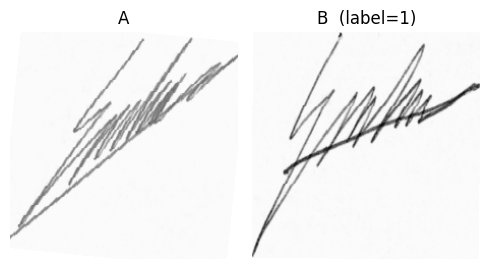

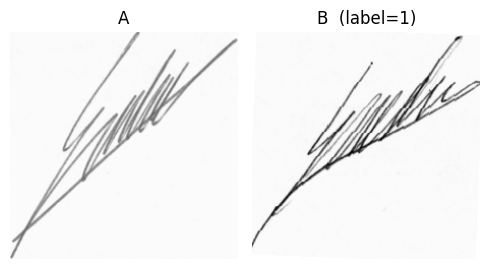

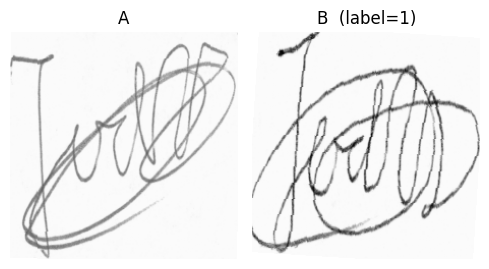

In [13]:
import matplotlib.pyplot as plt
import torch

def show_batch(dataloader, n=3):
    a, b, y = next(iter(dataloader))
    for i in range(min(n, a.size(0))):
        fig, axes = plt.subplots(1, 2, figsize=(5, 3))
        axes[0].imshow(((a[i].permute(1,2,0)*0.5)+0.5).cpu().numpy().squeeze(), cmap="gray")
        axes[0].set_title("A")
        axes[0].axis("off")
        axes[1].imshow(((b[i].permute(1,2,0)*0.5)+0.5).cpu().numpy().squeeze(), cmap="gray")
        axes[1].set_title(f"B  (label={int(y[i].item())})")
        axes[1].axis("off")
        plt.tight_layout()
        plt.show()

show_batch(train_loader, n=3)


# Reproducibility (seeds) + device

In [14]:
import random, numpy as np, torch

def set_seed(seed=1337):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(1337)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

# Siamese CNN (ResNet18 backbone + verification head)

In [15]:
import torch
import torch.nn as nn
import torchvision.models as models

class SiameseResNet18(nn.Module):
    """
    Shared ResNet18 backbone -> embedding head (D)
    Pair fusion: concat(f1, f2, |f1-f2|, f1*f2) -> MLP -> logit
    """
    def __init__(self, emb_dim=128, pretrained=True):
        super().__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
        # Keep it simple: we already feed 3-channel tensors via transforms
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])  # (B,512,1,1)
        self.proj = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, emb_dim)
        )
        # Fusion MLP
        in_f = emb_dim*4
        self.head = nn.Sequential(
            nn.Linear(in_f, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, 1)  # logit
        )

    def embed(self, x):
        x = self.backbone(x)          # (B,512,1,1)
        x = self.proj(x)              # (B,emb_dim)
        return x

    def forward(self, xa, xb):
        fa = self.embed(xa)
        fb = self.embed(xb)
        f_abs = torch.abs(fa - fb)
        f_mul = fa * fb
        z = torch.cat([fa, fb, f_abs, f_mul], dim=1)
        logit = self.head(z).squeeze(1)   # (B,)
        return logit, fa, fb

model = SiameseResNet18(emb_dim=128, pretrained=True).to(device)
sum(p.numel() for p in model.parameters())/1e6


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 138MB/s]


11.472321

# Train/Val utilities (loss, metrics, one epoch train/eval)

In [17]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch.nn.functional as F
from torch.optim import AdamW

def bce_logits_loss(logits, y):
    return F.binary_cross_entropy_with_logits(logits, y)

@torch.no_grad()
def eval_epoch(model, loader, device):
    model.eval()
    all_logits, all_y = [], []
    for a,b,y in loader:
        a,b,y = a.to(device), b.to(device), y.to(device)
        logits,_,_ = model(a,b)
        all_logits.append(logits.detach().cpu())
        all_y.append(y.detach().cpu())
    all_logits = torch.cat(all_logits)
    all_y = torch.cat(all_y)
    probs = torch.sigmoid(all_logits).numpy()
    preds = (probs >= 0.5).astype(int)
    y_true = all_y.numpy().astype(int)
    acc  = accuracy_score(y_true, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, preds, average="macro", zero_division=0)
    loss = F.binary_cross_entropy(torch.tensor(probs, dtype=torch.float32),
                                  torch.tensor(y_true, dtype=torch.float32)).item()
    return {"loss": loss, "acc": acc, "prec": prec, "rec": rec, "f1": f1}

def train_epoch(model, loader, device, optimizer):
    model.train()
    running_loss = 0.0
    for a,b,y in loader:
        a,b,y = a.to(device), b.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits,_,_ = model(a,b)
        loss = bce_logits_loss(logits, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * a.size(0)
    return running_loss / len(loader.dataset)


# Training loop (with LR for head/backbone, early unfreeze, plots)

Epoch 01 | train_loss=0.2433 | val_loss=0.2371 | val_acc=0.8954 | val_f1=0.8954
Epoch 02 | train_loss=0.1323 | val_loss=0.1528 | val_acc=0.9374 | val_f1=0.9373
Epoch 03 | train_loss=0.0358 | val_loss=0.0426 | val_acc=0.9842 | val_f1=0.9841
Epoch 04 | train_loss=0.0147 | val_loss=0.0160 | val_acc=0.9948 | val_f1=0.9948
Epoch 05 | train_loss=0.0098 | val_loss=0.0471 | val_acc=0.9816 | val_f1=0.9815
Epoch 06 | train_loss=0.0050 | val_loss=0.0700 | val_acc=0.9905 | val_f1=0.9905
Epoch 07 | train_loss=0.0097 | val_loss=0.4702 | val_acc=0.9523 | val_f1=0.9522
Epoch 08 | train_loss=0.0238 | val_loss=0.1740 | val_acc=0.9698 | val_f1=0.9697
Epoch 09 | train_loss=0.0013 | val_loss=0.0212 | val_acc=0.9925 | val_f1=0.9925
Epoch 10 | train_loss=0.0086 | val_loss=0.2350 | val_acc=0.9325 | val_f1=0.9325


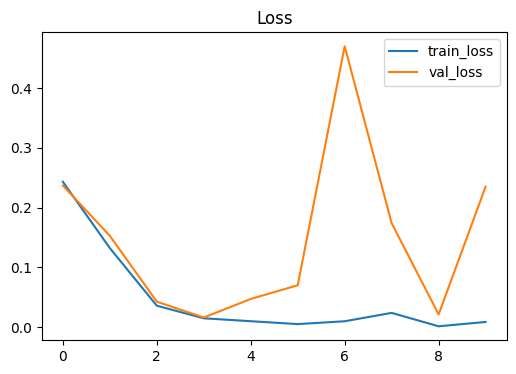

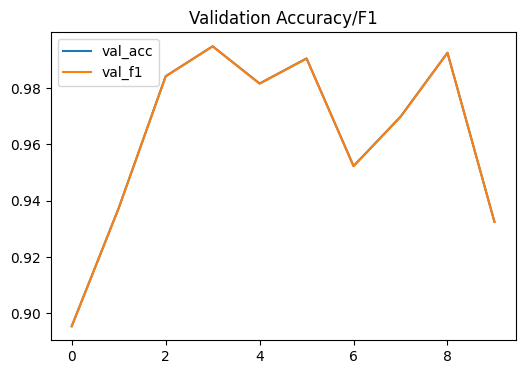

In [18]:
import matplotlib.pyplot as plt
from copy import deepcopy

EPOCHS          = 10
LR_HEAD         = 1e-3
LR_BACKBONE     = 1e-4
WEIGHT_DECAY    = 1e-4
UNFREEZE_AT     = 3   # after 3 epochs, unfreeze last ResNet block
BEST_STATE      = None
BEST_F1         = -1.0

# Freeze backbone first
for p in model.backbone.parameters():
    p.requires_grad = False

optimizer = AdamW([
    {"params": [p for n,p in model.named_parameters() if "backbone" not in n], "lr": LR_HEAD, "weight_decay": WEIGHT_DECAY},
    {"params": [p for n,p in model.named_parameters() if "backbone" in n and p.requires_grad], "lr": LR_BACKBONE, "weight_decay": WEIGHT_DECAY},
])

history = {"train_loss": [], "val_loss": [], "val_acc": [], "val_f1": []}

for epoch in range(1, EPOCHS+1):
    # Unfreeze backbone (partial fine-tune) after a few warm-up epochs
    if epoch == UNFREEZE_AT:
        for p in model.backbone.parameters():
            p.requires_grad = True
        optimizer = AdamW([
            {"params": [p for n,p in model.named_parameters() if "backbone" not in n], "lr": LR_HEAD, "weight_decay": WEIGHT_DECAY},
            {"params": [p for n,p in model.named_parameters() if "backbone" in n], "lr": LR_BACKBONE, "weight_decay": WEIGHT_DECAY},
        ])

    tr_loss = train_epoch(model, train_loader, device, optimizer)
    val_metrics = eval_epoch(model, val_loader, device)

    history["train_loss"].append(tr_loss)
    history["val_loss"].append(val_metrics["loss"])
    history["val_acc"].append(val_metrics["acc"])
    history["val_f1"].append(val_metrics["f1"])

    print(f"Epoch {epoch:02d} | train_loss={tr_loss:.4f} | val_loss={val_metrics['loss']:.4f} "
          f"| val_acc={val_metrics['acc']:.4f} | val_f1={val_metrics['f1']:.4f}")

    if val_metrics["f1"] > BEST_F1:
        BEST_F1 = val_metrics["f1"]
        BEST_STATE = deepcopy(model.state_dict())

# Restore best weights
if BEST_STATE is not None:
    model.load_state_dict(BEST_STATE)

# Plots
plt.figure(figsize=(6,4)); plt.plot(history["train_loss"], label="train_loss"); plt.plot(history["val_loss"], label="val_loss"); plt.legend(); plt.title("Loss"); plt.show()
plt.figure(figsize=(6,4)); plt.plot(history["val_acc"], label="val_acc"); plt.plot(history["val_f1"], label="val_f1"); plt.legend(); plt.title("Validation Accuracy/F1"); plt.show()


# Final evaluation on test set (metrics + ROC & confusion matrix)

Test classification report:

              precision    recall  f1-score   support

           0     1.0000    0.9859    0.9929      2772
           1     0.9871    1.0000    0.9935      2976

    accuracy                         0.9932      5748
   macro avg     0.9935    0.9930    0.9932      5748
weighted avg     0.9933    0.9932    0.9932      5748

ROC-AUC: 1.0


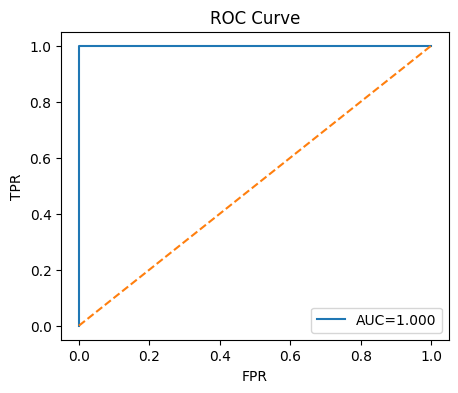

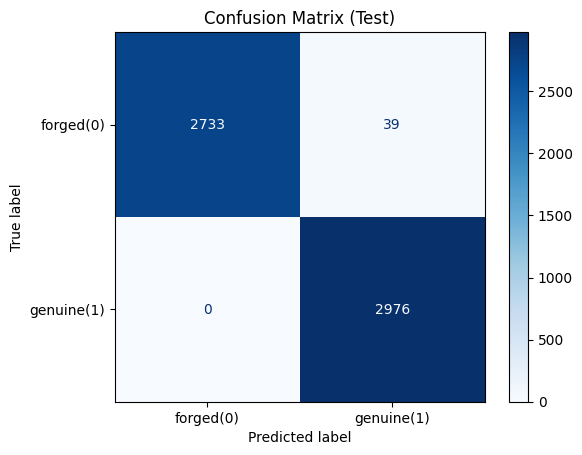

In [19]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np


@torch.no_grad()
def predict_logits(model, loader, device):
    model.eval()
    logits_all, y_all = [], []
    for a,b,y in loader:
        a,b = a.to(device), b.to(device)
        logits,_,_ = model(a,b)
        logits_all.append(logits.cpu())
        y_all.append(y)
    return torch.cat(logits_all).numpy(), torch.cat(y_all).numpy().astype(int)

test_logits, test_y = predict_logits(model, test_loader, device)
test_probs = 1 / (1 + np.exp(-test_logits))
test_pred  = (test_probs >= 0.5).astype(int)

print("Test classification report:\n")
print(classification_report(test_y, test_pred, digits=4))

try:
    auc = roc_auc_score(test_y, test_probs)
    print("ROC-AUC:", round(auc, 4))
    fpr, tpr, _ = roc_curve(test_y, test_probs)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve"); plt.legend(); plt.show()
except Exception as e:
    print("ROC-AUC not available:", e)

cm = confusion_matrix(test_y, test_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["forged(0)","genuine(1)"])
disp.plot(values_format='d', cmap="Blues")
plt.title("Confusion Matrix (Test)")
plt.show()


In [20]:
import os, json, time, torch

OUTDIR = "outputs_q1"
os.makedirs(OUTDIR, exist_ok=True)

torch.save(model.state_dict(), os.path.join(OUTDIR, "siamese_resnet18_best.pt"))
with open(os.path.join(OUTDIR, "history.json"), "w") as f:
    json.dump(history, f)

print("Saved to", OUTDIR)


Saved to outputs_q1
